# PINT Example notebook

The PINT "homepage":  https://github.com/nanograv/PINT

PINT will normally be run via a script, or for "work", via an interactive session like ipython or a frontend

## Times of Arrival (TOAs)

Read in some TOAs.

Note:  The first time that things get read in, lots of processing (can) happen.  Can take a few seconds.  But a "pickle" file is saved, so the next import (if nothing changed), things are much faster (typically ~1 second)

In [2]:
import pint.toa as toa
t = toa.get_TOAs("J0613-sim.tim")

INFO: Applying clock corrections. [pint.toa]
INFO: Getting IERS params and computing TDBs. [pint.toa]
INFO: Computing observatory positions and velocities. [pint.toa]


In [3]:
t.print_summary()

Number of TOAs:  1462
Number of commands:  2
Number of observatories:  1 ['gbt']
gbt TOAs (1462):
  Min error:     0.146 us
  Max error:     38.8 us
  Mean error:    3.35 us
  Median error:  1.54 us
  Error stddev:  4.53 us



In [4]:
t.get_mjds()[0]

53216.126681259244

Vast majority of the information is in an [Astropy Table](http://astropy.readthedocs.org/en/latest/table/):

In [5]:
t.table.colnames

['index',
 'mjd',
 'mjd_float',
 'error',
 'freq',
 'obs',
 'flags',
 'tdb',
 'tdbld',
 'ssb_obs_pos',
 'ssb_obs_vel',
 'obs_sun_pos']

Lots of cool things that tables can do...

In [6]:
tt = t.table
#tt.show_in_browser()

Can do fancy sorting, selecting, re-arranging very easily.

In [7]:
select = tt['error'] < 20
print(select)

[ True  True  True ...,  True  True  True]


In [8]:
tt['tdb'][select]

53216.1274241
53216.1274241
53216.1274241
53216.1274241
53216.1274241
53216.1274241
53216.1274241
53216.1340098
53216.1340098
53216.1340098
53216.1340098


Many PINT routines / classes / functions use [Astropy Units](http://astropy.readthedocs.org/en/latest/units/) internally or externally:

In [9]:
import astropy.units as u
t.get_errors() < 20 * u.ns

array([False, False, False, ..., False, False, False], dtype=bool)

The times in each row contain (or are derived from) [Astropy Time](http://astropy.readthedocs.org/en/latest/time/) objects:

In [10]:
t0 = tt['mjd'][0]

In [11]:
t0.tai

<Time object: scale='tai' format='pulsar_mjd' value=53216.1270516>

But the most useful timescale, TDB (and maybe soon others) are also stored as long double (i.e. "float96") Numpy arrays:

In [12]:
tt['tdbld'][:3]

53216.1274241
53216.1274241
53216.1274241


## Timing (or other) Models

Now let's define and load a timing model

In [14]:
import pint.models as models
m = models.get_model('J0613-sim.par')

In [15]:
print(m.as_parfile())

PSR                            J0613-0200
POSEPOCH            54890.000000000000000
PX                          1.11638926306 1 0.111363301398
RAJ                      6:13:43.97767520 1 9.83147324167e-10
DECJ                    -2:00:47.22538000 1 2.44045780433e-08
PMRA                        1.82779595278 1 0.0176467150286
PMDEC                       -10.338557736 1 0.0342648157615
F0                  326.60056202349007573 1 4.67708045e-12
F1              -1.0229704624634172473e-15 1 3.58956892683e-20
TZRMJD              54401.720778357950280
PEPOCH              54890.000000000000000
PLANET_SHAPIRO                          N
DM                          38.7775344453 1 0.000631748243622
PB                          1.19851257522 1 1.274978299e-11
PBDOT                                 0.0
A1                          1.09143421206 1 7.29224866087e-08
A1DOT                                 0.0
ECC                     5.28646359551e-06 1 3.82222685592e-07
EDOT                               

In [16]:
print m.RAJ.value, m.F0.value, m.T0.value

6.22888268756 326.600562023 53113.9550956


Timing models are basically composed of "delay" terms and "phase" terms:

In [17]:
m.delay_funcs

{'L1': [<bound method J0613-sim.solar_system_geometric_delay of <pint.models.timing_model.J0613-sim object at 0x11156ef10>>,
  <bound method J0613-sim.solar_system_shapiro_delay of <pint.models.timing_model.J0613-sim object at 0x11156ef10>>,
  <bound method J0613-sim.dispersion_delay of <pint.models.timing_model.J0613-sim object at 0x11156ef10>>],
 'L2': [<bound method J0613-sim.binarymodel_delay of <pint.models.timing_model.J0613-sim object at 0x11156ef10>>]}

In [18]:
m.phase_funcs

[<bound method J0613-sim.spindown_phase of <pint.models.timing_model.J0613-sim object at 0x11156ef10>>]

Can easily show/compute individual terms...

In [19]:
ds = m.solar_system_shapiro_delay(tt)
print(ds)

[  1.36588635e-05   1.36588635e-05   1.36588635e-05 ...,  -7.78619494e-07
  -7.78619494e-07  -7.78619498e-07]


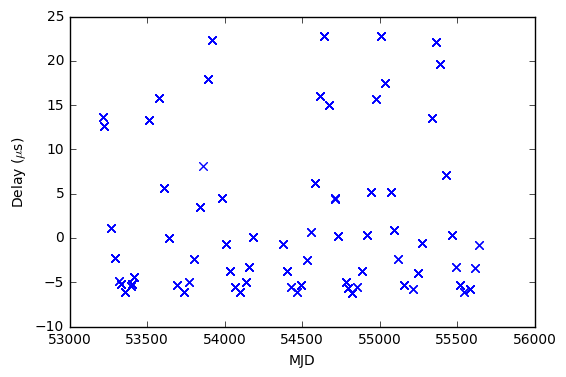

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(t.get_mjds(high_precision=False), ds*1e6, 'x')
plt.xlabel("MJD") ; plt.ylabel("Delay ($\mu$s)")

or all of the terms added together:

In [21]:
m.delay(tt)

array([ 383.42189435,  383.42233456,  383.4227785 , ...,  -42.364831  ,
        -42.36435585,  -42.36387685])

In [22]:
m.phase(tt)

Phase(int=<Column name='tdbld' dtype='float128' length=1462>
-33455540619.0
-33455540619.0
-33455540619.0
-33455540619.0
-33455540620.0
-33455540620.0
-33455540620.0
-33455540621.0
-33455354765.0
-33455354765.0
-33455354765.0
-33455354765.0
           ...
 34276095062.0
 34276095061.0
 34276095061.0
 34276095061.0
 34924562649.0
 34924562649.0
 34924562649.0
 34924562649.0
 34924562649.0
 34924562649.0
 34924562649.0
 34924562648.0, frac=<Column name='tdbld' dtype='float128' length=1462>
0.129232738167
0.130273494869
0.130822904408
0.127799611539
0.123268928379
0.133111756295
0.124778985977
0.132246188819
 0.13095825538
0.128953747451
0.127470262349
0.128128949553
           ...
0.163823828101
0.164243225008
0.163413535804
0.164021525532
 0.16853357479
0.168779201806
0.171340979636
0.170001294464
0.167892184108
0.167743381113
0.168957974762
0.167411573231)

## Residuals

In [23]:
import pint.residuals as r

In [24]:
rs = r.resids(t, m).phase_resids

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/table/column.py:263: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__eq__(other)


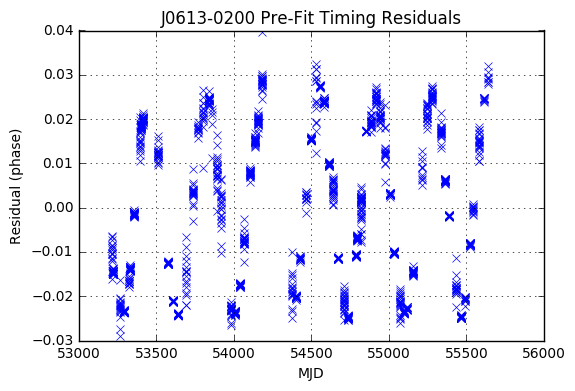

In [25]:
plt.plot(t.get_mjds(high_precision=False), rs, 'x')
plt.title("%s Pre-Fit Timing Residuals" % m.PSR.value)
plt.xlabel('MJD'); plt.ylabel('Residual (phase)')
plt.grid()


## Fitting and Post-Fit residuals

The fitter is *completely* separate from the model and the TOA code.  So you can use any type of fitter with some easy coding.  This example uses a very simple Powell minimizer from the SciPy optimize module. 

In [26]:
import pint.fitter as fit
f = fit.wls_fitter(t, m)

In [27]:
f.get_fitparams()

{'A1': <Quantity 1.0914342120578364 ls>,
 'DECJ': <Angle -2.013118161111111 deg>,
 'DM': <Quantity 38.77753444534659 pc / cm3>,
 'ECC': <Quantity 5.286463595509009e-06>,
 'F0': <Quantity 326.60056202349007573 Hz>,
 'F1': <Quantity -1.0229704624634172473e-15 Hz / s>,
 'OM': <Quantity 47.68151959744386 deg>,
 'PB': <Quantity 1.198512575222573 d>,
 'PMDEC': <Quantity -10.338557735985926 mas / yr>,
 'PMRA': <Quantity 1.8277959527833962 mas / yr>,
 'PX': <Quantity 1.1163892630643213 mas>,
 'RAJ': <Angle 6.228882687555556 hourangle>,
 'T0': <Time object: scale='tdb' format='mjd' value=53113.9550956>}

In [28]:
f.call_minimize()

('d_delay_d_Offset', 'd_phase_d_Offset')
('d_delay_d_PX', 'd_phase_d_PX')
d_delay_astrometry_d_PX
('d_delay_d_RAJ', 'd_phase_d_RAJ')
d_delay_astrometry_d_RAJ
('d_delay_d_DECJ', 'd_phase_d_DECJ')
d_delay_astrometry_d_DECJ
('d_delay_d_PMRA', 'd_phase_d_PMRA')
d_delay_astrometry_d_PMRA
('d_delay_d_PMDEC', 'd_phase_d_PMDEC')
d_delay_astrometry_d_PMDEC
('d_delay_d_F0', 'd_phase_d_F0')
('d_delay_d_F1', 'd_phase_d_F1')
('d_delay_d_DM', 'd_phase_d_DM')
d_delay_dispersion_d_DM
('d_delay_d_PB', 'd_phase_d_PB')
d_delay_binary_d_PB


AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
print "Best fit has reduced chi^2 of", f.resids.chi2_reduced
print "RMS in phase is", f.resids.phase_resids.std()
print "RMS in time is", f.resids.time_resids.std().to(u.us)
print "\n Best model is:"
print f.model.as_parfile()


In [ ]:
plt.errorbar(t.get_mjds(high_precision=False),
             f.resids.time_resids.to(u.us).value,
             t.get_errors().to(u.us).value, fmt='x')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel('MJD'); plt.ylabel('Residual (us)')
plt.grid()

## Other interesting things

We can make Barycentered TOAs in a single line!

In [29]:
m.get_barycentric_toas(tt)

<Quantity [ 53216.123, 53216.123, 53216.123,...,  55639.378, 55639.378,
            55639.378] d>